# Proyecto Movie Dataset


MINI DESCRIPCION

##### 1) User-based Approach

We will start with a basic user-based machine learning algorithm so we can do a premilinary analysis of this problem, our datasets and to be able to explain a basic funcition

In [22]:
#First Imports
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
#import torch
#from transformers import AutoTokenizer, AutoModel
np.random.seed(42)


In [3]:
# Reed CSV
linksTable = pd.read_csv("ml-latest-small/links.csv")
moviesTable = pd.read_csv("ml-latest-small/movies.csv")
ratingsTable = pd.read_csv("ml-latest-small/ratings.csv")
tagsTable = pd.read_csv("ml-latest-small/tags.csv")

We need to create a matrix with the ratings of every user to every movie. In the cases where the user have not seen the movie yet, we will fill it like a 0.

In [4]:
# Create matrix user-movie
user_movie_matrix  = ratingsTable.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)


With this accomplished, we now can calculate the similarity betweeen users. How? Each row is a vector of $R^n$ where n is the number of movies so if 2 users have similar ratings to the same movies their vector will be very similar. In the best case where they have the same ratings their vectors will be colinears.
</br> To calculate we will use cosine similarity that calculate the cosine between each row and throws a number between 0 and 1, closer to 1 closer are the users.

In [5]:
# Similarity between users
similarity = cosine_similarity(user_movie_matrix)
similarity_df = pd.DataFrame(similarity, index=user_movie_matrix .index, columns=user_movie_matrix.index)

We now can do a little matrix of the first 20 users and how similar they are.

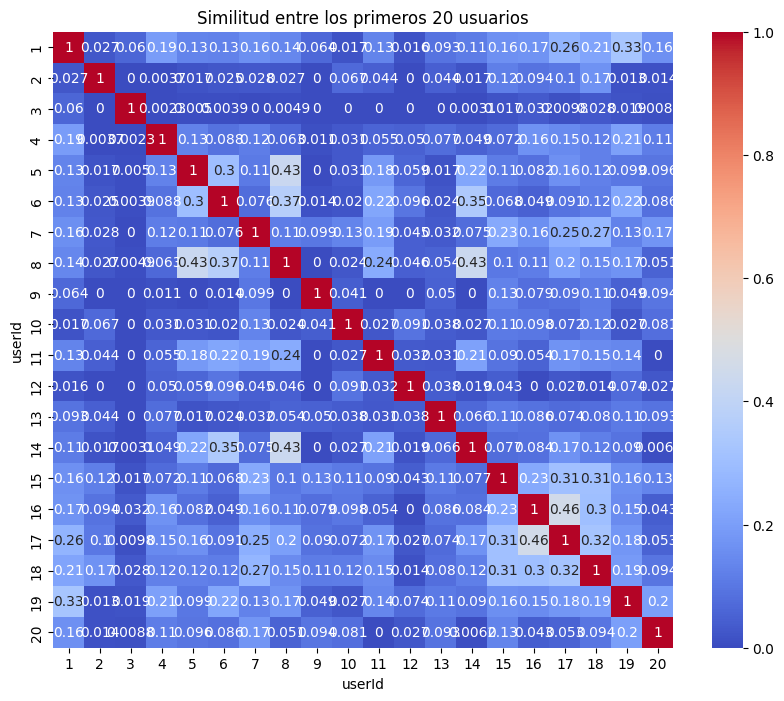

In [5]:
#See matrix 20x20 of similarity
plt.figure(figsize=(10,8))
sns.heatmap(similarity_df.iloc[:20, :20], cmap='coolwarm', annot=True)
plt.title("Similitud entre los primeros 20 usuarios")
plt.show()

Now it comes the more interesting thing of this, the prediction, the reccomendation of the movie. To do this we created a function that takes the user and sort the similarity between the other users. Then, we take the top 5 more similar, their neighbours. Finally we make a weighted average between those 5 users and sort the final calification. With this, we just need to take the ones with the better calification and that the objetive user have not yet seen.

In [6]:
def recomendar_peliculas(ratingsTable,similarity_df, usuario_id, n_vecinos=5, n_recomendaciones=10):
    # Verificar que el usuario existe
    if usuario_id not in similarity_df.index:
        raise ValueError(f"El usuario {usuario_id} no existe en la matriz de similitud.")
    
    # Obtener usuarios más similares (vecinos)
    vecinos = (
        similarity_df[usuario_id]
        .drop(index=usuario_id)
        .sort_values(ascending=False)
        .head(n_vecinos)
    )
    
    
    # Ratings de los vecinos
    ratings_vecinos = ratingsTable[ratingsTable['userId'].isin(vecinos.index)].copy()
    
    # Agregar columna de similitud
    ratings_vecinos['similarity'] = ratings_vecinos['userId'].map(vecinos)
    
    # Calcular rating ponderado por similitud
    ratings_vecinos['weighted_rating'] = ratings_vecinos['rating'] * ratings_vecinos['similarity']
    
    # Promedio ponderado de rating por película
    recomendacion_scores = (
        ratings_vecinos
        .groupby('movieId', as_index=True)
        .agg(weighted_mean=('weighted_rating', lambda x: np.sum(x) / np.sum(ratings_vecinos.loc[x.index, 'similarity'])))
        ['weighted_mean']
        .sort_values(ascending=False)
        .rename('score')
    )
    
    # Eliminar películas ya vistas por el usuario objetivo
    peliculas_vistas = ratingsTable[ratingsTable['userId'] == usuario_id]['movieId']
    recomendacion_scores = recomendacion_scores[~recomendacion_scores.index.isin(peliculas_vistas)]
    
    # Combinar con títulos de películas
    recomendaciones = (
        pd.DataFrame(recomendacion_scores.head(n_recomendaciones))
        .reset_index()
        .merge(moviesTable, on='movieId')[['movieId', 'title', 'score']]
    )
    recomendaciones.columns = ['movieId', 'title', 'score']
    
    return recomendaciones, vecinos

In [7]:
recomend = recomendar_peliculas(ratingsTable, similarity_df, usuario_id=17, n_vecinos=5, n_recomendaciones=10)
top10=recomend[0]
vecinosUsr=recomend[1]


In [8]:
top10


,movieId,title,score
0,68237,Moon (2009),5.0
1,72226,Fantastic Mr. Fox (2009),5.0
2,70286,District 9 (2009),5.0
3,55820,No Country for Old Men (2007),5.0
4,69481,"Hurt Locker, The (2008)",5.0
5,741,Ghost in the Shell (Kôkaku kidôtai) (1995),5.0
6,1199,Brazil (1985),5.0
7,1200,Aliens (1986),5.0
8,1527,"Fifth Element, The (1997)",5.0
9,44199,Inside Man (2006),5.0


In [32]:
vecinosUsr

userId
16     0.456096
400    0.452319
434    0.452304
247    0.438913
399    0.414196
Name: 17, dtype: float64

We now need to evaluate our model, te verify that it performs well. For that we decided to do a LOOCV approach. We will eliminate one of the best rated movies of a user and then we evaluate if it appears in the top 10. This algorithm will loop to be calculated in every user, so it might take some time

In [9]:
def evaluar_modelo_leave_one_out(ratingsTable, n_vecinos=5, k_recs=15):
    usuarios = ratingsTable['userId'].unique()
    #usuarios = np.random.choice(ratingsTable['userId'].unique(), size=200, replace=False)
    resultados = []
    
    for usuario in usuarios:
        # Select movies seen by the user
        peliculas_usuario = ratingsTable[
            (ratingsTable['userId'] == usuario) & (ratingsTable['rating'] >= 4.5)]['movieId'].values
        
        if len(peliculas_usuario) <= 1:
            continue  # this user has not "good" movies to recommend. 
        
        # Leve one of the movies out
        pelicula_test = np.random.choice(peliculas_usuario)
        
        # We "train" using every review but the one we randomly selected
        train_ratings = ratingsTable[
            ~((ratingsTable['userId'] == usuario) & (ratingsTable['movieId'] == pelicula_test))
        ]
        
        # We recalculate the cosine similaryty of the model
        user_movie_matrix = train_ratings.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)
        similarity = cosine_similarity(user_movie_matrix)
        sim_df = pd.DataFrame(similarity, index=user_movie_matrix.index, columns=user_movie_matrix.index)
        
        # Reccomendation
        try:
            recs = recomendar_peliculas(train_ratings, sim_df, usuario_id=usuario, n_vecinos=n_vecinos, n_recomendaciones=k_recs)[0]
        except:
            continue
        
        # We evaluate if the movie is in the top
        acierto = int(pelicula_test in recs['movieId'].values)
        resultados.append(acierto)
    
    precision = np.mean(resultados)
    print(f"Precision@{k_recs}: {precision:.3f}")
    return precision

In [10]:
#Evaluate
precisionLOO = evaluar_modelo_leave_one_out(ratingsTable, n_vecinos=5, k_recs=10)

KeyboardInterrupt: 

Like we can see, this model doesn't perform well, but it might be because of the way we are evaluating. Instead of leaving only one out, we will try leaving more.

In [35]:
def evaluar_modelo_leave_many_out(ratingsTable, n_vecinos=5, k_recs=15, n_test=3):

    usuarios = ratingsTable['userId'].unique()
    resultados = []

    for usuario in usuarios:
        # Seleccionar películas "buenas" del usuario
        peliculas_usuario = ratingsTable[
            (ratingsTable['userId'] == usuario) & (ratingsTable['rating'] >= 4.5)
        ]['movieId'].values
        
        if len(peliculas_usuario) <= n_test:
            continue  # usuario no tiene suficientes películas "buenas" para test
        
        # Dejar n_test películas fuera para test
        peliculas_test = np.random.choice(peliculas_usuario, size=n_test, replace=False)
        
        # Train = resto de películas
        train_ratings = ratingsTable[
            ~((ratingsTable['userId'] == usuario) & ratingsTable['movieId'].isin(peliculas_test))
        ]
        
        # Recalcular matriz usuario-película (solo train)
        user_movie_matrix = train_ratings.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)
        similarity = cosine_similarity(user_movie_matrix)
        sim_df = pd.DataFrame(similarity, index=user_movie_matrix.index, columns=user_movie_matrix.index)
        
        # Recomendaciones
        try:
            recs = recomendar_peliculas(train_ratings, sim_df, usuario_id=usuario, n_vecinos=n_vecinos, n_recomendaciones=k_recs)[0]
        except:
            continue
        
        # Evaluar: ¿alguna de las películas test está en las recomendadas?
        acierto = int(any(pelicula in recs['movieId'].values for pelicula in peliculas_test))
        resultados.append(acierto)
    
    precision = np.mean(resultados)
    print(f"Precision@{k_recs} (Leave-{n_test}-Out): {precision:.3f}")
    return precision

In [ ]:
precisionLMO = evaluar_modelo_leave_many_out(ratingsTable, n_vecinos=5, k_recs=15, n_test=4)
print(precisionLMO)

Precision@15 (Leave-4-Out): 0.200
0.19963031423290203


We tried different options but we still have a low precision. We decided to investigate a little further our cosine matrix.

Matriz por cada usuario: 
        media  mediana  maximo
userId                        
1        0.13     0.12    0.36
2        0.05     0.03    0.30
3        0.01     0.00    0.08
4        0.09     0.08    0.32
5        0.12     0.09    0.52
...       ...      ...     ...
606      0.13     0.11    0.40
607      0.13     0.13    0.36
608      0.18     0.16    0.51
609      0.11     0.08    0.60
610      0.14     0.12    0.48

[610 rows x 3 columns]
Media de los maximos de todos los usuarios: 
0.39
Mediana de los maximos de todos los usuarios: 
0.38
Similitud maxima: 
0.81
Cuantiles: 
0.25    0.29
0.50    0.38
0.75    0.48
1.00    0.81
dtype: float64


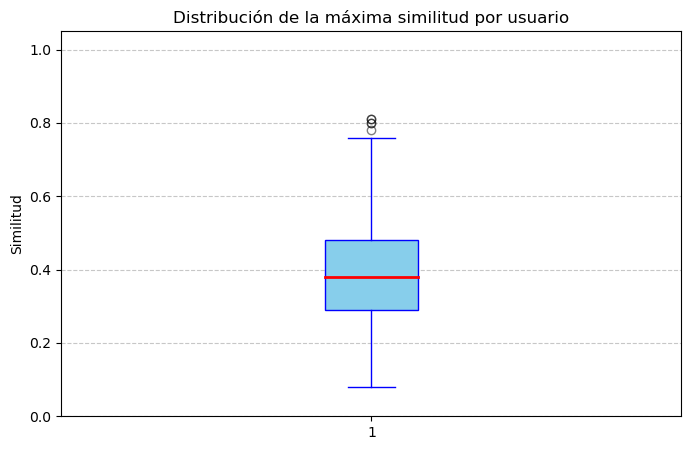

In [36]:
sim_df = similarity_df.copy()

# Reemplazar la diagonal (similitud consigo mismo) por NaN
np.fill_diagonal(sim_df.values, np.nan)

# Media de similitud por usuario (por fila)
media_por_usuario = sim_df.mean(axis=1).round(2)

# Mediana de similitud por usuario (por fila)
mediana_por_usuario = sim_df.median(axis=1).round(2)

# Maxima de similitud por usuario (por fila)
max_por_usuario = sim_df.max(axis=1).round(2)

# Estadísticas de las máximas
media_max = round(max_por_usuario.mean(),2)
mediana_max = round(max_por_usuario.median(),2)
max_max = round(max_por_usuario.max(), 2)
cuantiles = round(max_por_usuario.quantile([0.25, 0.5, 0.75, 1.0]), 2)

# Combinar en un solo DataFrame si quieres
resumen_similitud = pd.DataFrame({
    'media': media_por_usuario,
    'mediana': mediana_por_usuario,
    'maximo': max_por_usuario
})


print("Matriz por cada usuario: ")
print(resumen_similitud)
print("Media de los maximos de todos los usuarios: ")
print(media_max)
print("Mediana de los maximos de todos los usuarios: ")
print(mediana_max)
print("Similitud maxima: ")
print(max_max)
print("Cuantiles: ")
print(cuantiles)


# Crear boxplot
plt.figure(figsize=(8,5))
plt.boxplot(max_por_usuario, vert=True, patch_artist=True, 
            boxprops=dict(facecolor='skyblue', color='blue'),
            medianprops=dict(color='red', linewidth=2),
            whiskerprops=dict(color='blue'),
            capprops=dict(color='blue'),
            flierprops=dict(marker='o', color='orange', alpha=0.5))

plt.title('Distribución de la máxima similitud por usuario')
plt.ylabel('Similitud')
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

With this quick analysis we see that the similarity between the users is not that good, only a few otliers accomplish a similarity pass 0.8 so maybe the way we are calculating the similarity is also a problem.
</br>A theory that might explain this is that we fill a matrix of 0, and beacuse most people dont't see the majority of movies, we probably have more 0 than actual ratings that separate even more our predictions.
</br>Also, we decided to try a different method to calculate our error, we will leave a prediction out but we will calculate the difference between the real rating and the weighted average of the neighbours.

In [44]:
#Crea nueva matriz pero sin los 0 en los vacios, solo Nan
user_movie_matrixNaN = ratingsTable.pivot_table(index='userId', columns='movieId', values='rating')


In [45]:
# Centrar por la media: restar en cada rating el promedio de review del usuario
user_mean_centered = user_movie_matrixNaN.sub(user_movie_matrixNaN.mean(axis=1), axis=0)


In [46]:
#Crear una matriz sparce (mejora la memoria)
sparse_matrix = csr_matrix(user_mean_centered.fillna(0))


In [47]:
#Ahora los 0 no van a ser tan importantes como antes
similarityMeanReview = cosine_similarity(sparse_matrix)
similarityMeanReview_df = pd.DataFrame(similarityMeanReview, index=user_movie_matrixNaN.index, columns=user_movie_matrixNaN.index)

In [ ]:
def evaluar_modelo_leave_one_out_mse(ratingsTable, n_vecinos=5):

    usuarios = ratingsTable['userId'].unique()
    
    sq_errors = []
    abs_errors = []
    count_preds = 0

    for usuario in usuarios:
        # Seleccionar películas con rating "bueno" (puedes cambiar el umbral o usar todas)
        peliculas_usuario = ratingsTable[
            (ratingsTable['userId'] == usuario) 
        ]['movieId'].values
        
        # Si el usuario tiene <=1 rating, no podemos hacer leave-one-out
        if len(peliculas_usuario) <= 1:
            continue
        
        # Elegimos una película a dejar fuera (test)
        pelicula_test = np.random.choice(peliculas_usuario)
        
        # Crear set de entrenamiento sin esa fila
        train_ratings = ratingsTable[
            ~((ratingsTable['userId'] == usuario) & (ratingsTable['movieId'] == pelicula_test))
        ].copy()
        
        # Valor real (target) — lo buscamos en la tabla original
        r_u_i = float(ratingsTable[
            (ratingsTable['userId'] == usuario) & (ratingsTable['movieId'] == pelicula_test)
        ]['rating'].iloc[0])
        
        # Construir matriz usuario-película (NaN para no calificadas)
        user_movie_matrix = train_ratings.pivot_table(index='userId', columns='movieId', values='rating')
        
        # Si el usuario ya no aparece en la matriz (edge case), saltar
        if usuario not in user_movie_matrix.index:
            continue
        
        # Mean-centering por usuario (usaremos estas medias para la predicción)
        user_means = user_movie_matrix.mean(axis=1)
        user_mean_centered = user_movie_matrix.sub(user_means, axis=0)
        
        # Matriz esparsa y similitud
        sparse_matrix = csr_matrix(user_mean_centered.fillna(0))
        sim_matrix = cosine_similarity(sparse_matrix)
        sim_df = pd.DataFrame(sim_matrix, index=user_movie_matrix.index, columns=user_movie_matrix.index)
        
        # Obtener vecinos top-n_vecinos del usuario objetivo (si no aparecen, skip)
        if usuario not in sim_df.index:
            continue
        vecinos = sim_df[usuario].drop(index=usuario).sort_values(ascending=False).head(n_vecinos)
        vecinos = vecinos[vecinos > 0]  # opcional: usar sólo similitudes positivas
        
        if vecinos.empty:
            # No hay vecinos con similitud positiva; opcionalmente podríamos predecir la media del usuario
            # Aquí lo saltamos
            continue
        
        # Obtener ratings de los vecinos para la pelicula_test dentro de train_ratings
        ratings_vecinos_para_peli = train_ratings[
            (train_ratings['movieId'] == pelicula_test) & (train_ratings['userId'].isin(vecinos.index))
        ].copy()
        
        # Si ninguno de los vecinos tiene rating para esa pelicula, no podemos predecir; saltamos
        if ratings_vecinos_para_peli.empty:
            continue
        
        # Mapear la media de cada vecino (over train set) y la similitud
        ratings_vecinos_para_peli['user_mean'] = ratings_vecinos_para_peli['userId'].map(user_means)
        ratings_vecinos_para_peli['similarity'] = ratings_vecinos_para_peli['userId'].map(vecinos)
        
        # Calcular numerador y denominador para la fórmula ajustada
        # nota: usamos r_vi - mean_v
        ratings_vecinos_para_peli['diff'] = ratings_vecinos_para_peli['rating'] - ratings_vecinos_para_peli['user_mean']
        numerador = (ratings_vecinos_para_peli['similarity'] * ratings_vecinos_para_peli['diff']).sum()
        denominador = ratings_vecinos_para_peli['similarity'].abs().sum()
        
        if denominador == 0:
            continue
        
        # media del usuario objetivo (sobre train)
        mean_u = user_means.loc[usuario]
        # predicción final
        r_hat = mean_u + numerador / denominador
        
        # Guardar errores
        sq_errors.append((r_u_i - r_hat) ** 2)
        abs_errors.append(abs(r_u_i - r_hat))
        count_preds += 1

    if count_preds == 0:
        raise ValueError("No se pudo predecir ninguna instancia (revisa vecinos/umbral).")
    
    mse = np.mean(sq_errors)
    rmse = np.sqrt(mse)
    mae = np.mean(abs_errors)
    
    print(f"Predicciones: {count_preds}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    return {'n_preds': count_preds, 'mse': mse, 'rmse': rmse, 'mae': mae}

In [51]:
evaluar_modelo_leave_one_out_mse(ratingsTable, n_vecinos=5)

Predicciones: 337, MSE: 1.0185, RMSE: 1.0092, MAE: 0.7883


{'n_preds': 337,
 'mse': 1.0185291155724854,
 'rmse': 1.0092220348231034,
 'mae': 0.7883237739993741}

With this we obtained a mse of 1, meaning that in average if I put 3 stars in a movie the prediction will give a 3±1 to the movie. Its not bad, put it could be better.

##### 2) Content-Based Approach

Now, we will try a different path, we will have the decriptions of the movies and try to make a prediction based on that and maybe other key labels to predict movies.
We will merge our movies with a description from another dataset and try to make predictions based on that.

In [11]:
moviesMetadata = pd.read_csv("movies_metadata.csv")

C:\Users\garci\AppData\Local\Temp\ipykernel_2372\1753417259.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  moviesMetadata = pd.read_csv("movies_metadata.csv")


In [12]:
moviesMetadata['imdb_id_numeric'] = moviesMetadata['imdb_id'].str.replace('tt', '')

In [13]:
moviesMetadata

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,imdb_id_numeric
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,0114709
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,0113497
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,0113228
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,0114885
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,0113041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0,6209470
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0,2028550
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0,0303758
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0,0008536


In [14]:

linksTable['imdbId_str'] = linksTable['imdbId'].astype(int).astype(str).str.zfill(7)


In [15]:
# LeftJoin
movies_merged = linksTable.merge(
    moviesMetadata,
    left_on='imdbId_str',
    right_on='imdb_id_numeric',
    how='left'
)




In [16]:
movies_merged_coinc=movies_merged[movies_merged['title'].notna()]

In [17]:
movies_merged_coinc=movies_merged_coinc[['movieId', 'overview']]


In [18]:
# inner Join
movies_merged_description = moviesTable.merge(
    movies_merged_coinc,
    left_on='movieId',
    right_on='movieId',
    how='inner'
)


In [19]:
movies_merged_description=movies_merged_description[movies_merged_description['overview'].notna()]

In [20]:
movies_merged_description

,movieId,title,genres,overview
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"Led by Woody, Andy's toys live happily in his ..."
1,2,Jumanji (1995),Adventure|Children|Fantasy,When siblings Judy and Peter discover an encha...
2,3,Grumpier Old Men (1995),Comedy|Romance,A family wedding reignites the ancient feud be...
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"Cheated on, mistreated and stepped on, the wom..."
4,5,Father of the Bride Part II (1995),Comedy,Just when George Banks has recovered from his ...
...,...,...,...,...
9523,175705,Themroc (1973),Comedy|Horror,"Made without proper language, just gibberish a..."
9524,175707,A German Life (2016),Documentary,"Brunhilde Pomsel describes herself as an ""apol..."
9525,175743,Self-criticism of a Bourgeois Dog (2017),Comedy,A bourgeois dog confesses how he was transform...
9526,175781,Der Herr Karl (1961),Comedy,No overview found.


In [21]:
movies_merged_description['content'] = movies_merged_description['genres'].str.replace('|',' ') + " " + movies_merged_description['overview']
movies_merged_description = movies_merged_description.drop_duplicates(subset='movieId').reset_index(drop=True)


Now we have a column with the description and genres of the movie. We will try to match movies simiarity and try to make a recomendation

In [34]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_merged_description['content'])



In [35]:
# cosine_sim[i,j] = similaridad entre pelicula i y pelicula j

cosine_sim_TFIDF = cosine_similarity(tfidf_matrix)

In [36]:
#See matrix 20x20 of similarity
cosine_sim_df = pd.DataFrame(cosine_sim_TFIDF, index=movies_merged_description['title'], columns=movies_merged_description['title'])

In [ ]:
def recommend_for_user_content(user_id, ratings_df, movies_df, cosine_sim, top_n=10):
    # get user's rated movies
    user_rated = ratings_df[ratings_df['userId'] == user_id]

    # keep only liked ones (rating >= 4)
    liked = user_rated[user_rated['rating'] >= 4]

    if liked.empty:
        return "No le gusta ninguna película"

    sim_scores = np.zeros(cosine_sim.shape[0])

    # loop through liked movies
    for _, row in liked.iterrows():
        # find that movie in the movies_df (if exists)
        match = movies_df[movies_df['movieId'] == row['movieId']]

        if match.empty:
            continue  # skip if movie not in movies_df

        movie_idx = match.index[0]  # position in DataFrame = row in cosine_sim
        sim_scores += cosine_sim[movie_idx] * row['rating']

    sim_scores /= len(liked)

    # remove already rated movies
    rated_positions = movies_df[movies_df['movieId'].isin(user_rated['movieId'])].index
    sim_scores[rated_positions] = 0

    # get top N indices
    top_indices = sim_scores.argsort()[-top_n:][::-1]

    return movies_df.iloc[top_indices][['movieId', 'title']]


Finally we have a cosine similarity matrix like before but now with all the movies instead of users. Lets try to make a function that makes recommendations to the users.

This function takes all the movies a user likes, calculates how similar each one is to every other movie, weights those similarities based on the user’s ratings, and then sums them up to rank the most similar movies.
Finally it removes the movies that the user already has seen.

In [ ]:
print(recommend_for_user_content(16, ratingsTable, movies_merged_description, cosine_sim_TFIDF, top_n=10))


      movieId                                           title
719       942                                    Laura (1944)
4815     7217                             Dark Passage (1947)
1631     2182                           Wrong Man, The (1956)
4980     7728          Postman Always Rings Twice, The (1946)
2619     3513                      Rules of Engagement (2000)
4082     5876                      Quiet American, The (2002)
7978    98124  Batman: The Dark Knight Returns, Part 1 (2012)
508       592                                   Batman (1989)
9225   159077                              The Meddler (2016)
5605    27311       Batman Beyond: Return of the Joker (2000)


In [32]:
# Split each user's ratings into train (to generate recommendations) and test (to evaluate)
def train_test_split_ratings(ratings_df, test_size=0.2):
    train_list = []
    test_list = []
    for user_id, group in ratings_df.groupby('userId'):
        if len(group) < 3:
            continue  # skip users with too few ratings
        train, test = train_test_split(group, test_size=test_size, random_state=42)
        train_list.append(train)
        test_list.append(test)
    return pd.concat(train_list), pd.concat(test_list)

train_ratings, test_ratings = train_test_split_ratings(ratingsTable)

In [ ]:
def precision_recall_at_k(user_id, train_ratings, test_ratings, movies_df, cosine_sim, k=10):
    recs = recommend_for_user_content(user_id, train_ratings, movies_df, cosine_sim, top_n=k)
    if isinstance(recs, str):
        return None, None, None  # user with no recommendations
    
    true_likes = test_ratings[
        (test_ratings['userId'] == user_id) & (test_ratings['rating'] >= 4)
    ]['movieId']
    if true_likes.empty:
        return None, None, None

    recommended_ids = recs['movieId'].values
    hits = np.isin(recommended_ids, true_likes)

    precision = hits.sum() / k
    recall = hits.sum() / len(true_likes)
    # average precision for MAP
    ap = np.mean([hits[:i+1].sum() / (i+1) for i in range(len(hits)) if hits[i]]) if hits.any() else 0
    return precision, recall, ap



In [38]:
# --- evaluate all users and average ---
results = []
for user_id in test_ratings['userId'].unique():
    p, r, ap = precision_recall_at_k(user_id, train_ratings, test_ratings, movies_merged_description, cosine_sim_TFIDF, k=5)
    if p is not None:
        results.append((p, r, ap))

# --- global (overall) accuracy ---
overall_precision = np.mean([p for p, _, _ in results])
overall_recall = np.mean([r for _, r, _ in results])
overall_map = np.mean([ap for _, _, ap in results])

print(f"Overall Precision@10: {overall_precision:.3f}")
print(f"Overall Recall@10:    {overall_recall:.3f}")
print(f"Overall MAP@10:       {overall_map:.3f}")

Overall Precision@10: 0.024
Overall Recall@10:    0.016
Overall MAP@10:       0.057


In [26]:
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(movies_merged_description['content'], show_progress_bar=True)
cosine_sim_embeddings = cosine_similarity(embeddings)

Batches: 100%|██████████| 298/298 [01:44<00:00,  2.84it/s]


In [33]:
# --- evaluate all users and average ---
results = []
for user_id in test_ratings['userId'].unique():
    p, r, ap = precision_recall_at_k(user_id, train_ratings, test_ratings, movies_merged_description, cosine_sim_embeddings, k=5)
    if p is not None:
        results.append((p, r, ap))

# --- global (overall) accuracy ---
overall_precision = np.mean([p for p, _, _ in results])
overall_recall = np.mean([r for _, r, _ in results])
overall_map = np.mean([ap for _, _, ap in results])

print(f"Overall Precision@10: {overall_precision:.3f}")
print(f"Overall Recall@10:    {overall_recall:.3f}")
print(f"Overall MAP@10:       {overall_map:.3f}")

Overall Precision@10: 0.007
Overall Recall@10:    0.004
Overall MAP@10:       0.016


#### 3) Hybrid


In [24]:
def content_based_scores(user_id, ratings_df, movies_df, cosine_sim):
    user_rated = ratings_df[ratings_df['userId'] == user_id]
    liked = user_rated[user_rated['rating'] >= 4]

    if liked.empty:
        return pd.DataFrame(columns=['movieId', 'cb_score'])

    sim_scores = np.zeros(cosine_sim.shape[0])
    for _, row in liked.iterrows():
        match = movies_df[movies_df['movieId'] == row['movieId']]
        if match.empty:
            continue
        movie_idx = match.index[0]
        sim_scores += cosine_sim[movie_idx] * row['rating']

    rated_positions = movies_df[movies_df['movieId'].isin(user_rated['movieId'])].index
    sim_scores[rated_positions] = 0

    return pd.DataFrame({
        'movieId': movies_df['movieId'],
        'cb_score': sim_scores
    })


In [25]:
def cf_based_scores(ratings_df, similarity_df, user_id, n_vecinos=5):
    if user_id not in similarity_df.index:
        return pd.DataFrame(columns=['movieId', 'cf_score'])
    
    vecinos = similarity_df[user_id].drop(index=user_id).sort_values(ascending=False).head(n_vecinos)
    ratings_vecinos = ratings_df[ratings_df['userId'].isin(vecinos.index)].copy()
    ratings_vecinos['similarity'] = ratings_vecinos['userId'].map(vecinos)
    ratings_vecinos['weighted_rating'] = ratings_vecinos['rating'] * ratings_vecinos['similarity']
    
    recomendacion_scores = (
        ratings_vecinos
        .groupby('movieId')
        .agg(cf_score=('weighted_rating', lambda x: np.sum(x) / np.sum(ratings_vecinos.loc[x.index, 'similarity'])))
        .reset_index()
    )
    return recomendacion_scores


In [26]:
def hybrid_recommendations(user_id, ratings_df, movies_df, cosine_sim, similarity_df, alpha=0.5, top_n=10):
    # get both score tables
    cb = content_based_scores(user_id, ratings_df, movies_df, cosine_sim)
    cf = cf_based_scores(ratings_df, similarity_df, user_id, n_vecinos=5)
    
    # merge on movieId
    hybrid = pd.merge(cb, cf, on='movieId', how='outer').fillna(0)
    
    # final weighted score
    hybrid['final_score'] = alpha * hybrid['cf_score'] + (1 - alpha) * hybrid['cb_score']
    
    # remove seen movies
    seen = ratings_df[ratings_df['userId'] == user_id]['movieId']
    hybrid = hybrid[~hybrid['movieId'].isin(seen)]
    
    # attach movie titles
    hybrid = hybrid.merge(movies_df[['movieId', 'title']], on='movieId', how='left')
    
    return hybrid.sort_values('final_score', ascending=False).head(top_n)


In [27]:
recommendations = hybrid_recommendations(
    user_id=17,
    ratings_df=ratingsTable,
    movies_df=movies_merged_description,
    cosine_sim=cosine_sim_TFIDF,
    similarity_df=similarity_df,
    alpha=0.6,   # more weight to CF
    top_n=10
)

print(recommendations[['title', 'final_score']])


                                                  title  final_score
6923                            Hurt Locker, The (2008)     6.049416
8518  Star Wars: Episode VII - The Force Awakens (2015)     5.884879
6941      Harry Potter and the Half-Blood Prince (2009)     5.582351
909                            Great Escape, The (1963)     5.570280
913                    Manchurian Candidate, The (1962)     5.566446
2932                                     Traffic (2000)     5.563114
7614                      Dark Knight Rises, The (2012)     5.509806
6203                             Children of Men (2006)     5.351776
1099                          Fifth Element, The (1997)     5.340516
2278                                 Toy Story 2 (1999)     5.300148


In [ ]:
def precision_recall_at_k_hybrid(user_id, train_ratings, test_ratings, movies_df, cosine_sim, similarity_df, alpha=0.5, k=10):
    recs = hybrid_recommendations(user_id, train_ratings, movies_df, cosine_sim, similarity_df, alpha=alpha, top_n=k)
    if recs is None or recs.empty:
        return None, None, None

    # Dynamically determine what counts as "liked"
    max_rating = test_ratings['rating'].max()
    threshold = 0.8 * max_rating  # top 20% of rating scale (e.g. 4 if max=5, or 8 if max=10)

    true_likes = test_ratings[
        (test_ratings['userId'] == user_id) & (test_ratings['rating'] >= threshold)
    ]['movieId'].values
    if len(true_likes) == 0:
        return None, None, None

    recommended_ids = recs['movieId'].values
    hits = np.isin(recommended_ids, true_likes)

    precision = hits.sum() / k
    recall = hits.sum() / len(true_likes)
    ap = np.mean([hits[:i+1].sum() / (i+1) for i in range(len(hits)) if hits[i]]) if hits.any() else 0
    
    return precision, recall, ap


In [29]:
def evaluate_hybrid(train_ratings, test_ratings, movies_df, cosine_sim, similarity_df, alpha=0.5, k=10):
    results = []
    for user_id in test_ratings['userId'].unique():
        p, r, ap = precision_recall_at_k_hybrid(user_id, train_ratings, test_ratings, movies_df, cosine_sim, similarity_df, alpha, k)
        if p is not None:
            results.append((p, r, ap))

    if not results:
        print("⚠️ No users with enough data to evaluate.")
        return None

    overall_precision = np.mean([p for p, _, _ in results])
    overall_recall = np.mean([r for _, r, _ in results])
    overall_map = np.mean([ap for _, _, ap in results])

    print(f"📊 Precision@{k}: {overall_precision:.3f}")
    print(f"📈 Recall@{k}:    {overall_recall:.3f}")
    print(f"🏅 MAP@{k}:       {overall_map:.3f}")
    
    return overall_precision, overall_recall, overall_map


In [ ]:
train_ratings, test_ratings = train_test_split_ratings(ratingsTable)

# Try different alpha values to see what balance performs best
for alpha in [0.2, 0.5, 0.8]:
    print(f"\n--- Hybrid model (alpha={alpha}) ---")
    evaluate_hybrid(train_ratings, test_ratings, movies_merged_description, cosine_sim_TFIDF, similarity_df, alpha=alpha, k=10)



--- Hybrid model (alpha=0.2) ---


C:\Users\garci\AppData\Local\Temp\ipykernel_27072\2358146337.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  hybrid = pd.merge(cb, cf, on='movieId', how='outer').fillna(0)


📊 Precision@10: 0.013
📈 Recall@10:    0.019
🏅 MAP@10:       0.036

--- Hybrid model (alpha=0.5) ---


C:\Users\garci\AppData\Local\Temp\ipykernel_27072\2358146337.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  hybrid = pd.merge(cb, cf, on='movieId', how='outer').fillna(0)


📊 Precision@10: 0.028
📈 Recall@10:    0.051
🏅 MAP@10:       0.105

--- Hybrid model (alpha=0.8) ---


C:\Users\garci\AppData\Local\Temp\ipykernel_27072\2358146337.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  hybrid = pd.merge(cb, cf, on='movieId', how='outer').fillna(0)


📊 Precision@10: 0.064
📈 Recall@10:    0.098
🏅 MAP@10:       0.171


In [30]:
print(f"\n--- Hybrid model (alpha={0.6}) ---")
evaluate_hybrid(train_ratings, test_ratings, movies_merged_description, cosine_sim_TFIDF, similarity_df, alpha=0.6, k=10)



--- Hybrid model (alpha=0.6) ---


C:\Users\garci\AppData\Local\Temp\ipykernel_27072\2358146337.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  hybrid = pd.merge(cb, cf, on='movieId', how='outer').fillna(0)


📊 Precision@10: 0.076
📈 Recall@10:    0.105
🏅 MAP@10:       0.197


(np.float64(0.07616666666666667),
 np.float64(0.10499171900011242),
 np.float64(0.1974867724867725))

In [ ]:

model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(movies_merged_description['content'], show_progress_bar=True)
cosine_sim_embeddings = cosine_similarity(embeddings)

C:\Users\garci\AppData\Roaming\Python\Python313\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\garci\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Batches: 100%|██████████| 298/298 [01:47<00:00,  2.77it/s]


In [36]:


def hybrid_predicted_ratings(user_id, ratings_df, movies_df, cosine_sim, similarity_df, alpha=0.5):
    """
    Returns predicted ratings for all unseen movies for a given user.
    """
    cb = content_based_scores(user_id, ratings_df, movies_df, cosine_sim)
    cf = cf_based_scores(ratings_df, similarity_df, user_id, n_vecinos=5)

    if cb['cb_score'].max() > 0:
        cb['cb_score'] = (cb['cb_score'] - cb['cb_score'].min()) / (cb['cb_score'].max() - cb['cb_score'].min())
    if cf['cf_score'].max() > 0:
        cf['cf_score'] = (cf['cf_score'] - cf['cf_score'].min()) / (cf['cf_score'].max() - cf['cf_score'].min())
    
    hybrid = pd.merge(cb, cf, on='movieId', how='outer').fillna(0)
    hybrid['final_score'] = alpha * hybrid['cf_score'] + (1 - alpha) * hybrid['cb_score']

    # Clip or normalize predictions to match rating scale
    if not hybrid['final_score'].empty:
        min_score, max_score = hybrid['final_score'].min(), hybrid['final_score'].max()
        if max_score > min_score:  # avoid divide by zero
            hybrid['pred_rating'] = 1 + 4 * (hybrid['final_score'] - min_score) / (max_score - min_score)
        else:
            hybrid['pred_rating'] = 3  # neutral value if constant scores
    else:
        hybrid['pred_rating'] = []

    return hybrid[['movieId', 'pred_rating']]

def rmse_mse_hybrid(train_ratings, test_ratings, movies_df, cosine_sim, similarity_df, alpha=0.5):
    """
    Compute RMSE and MSE across all users in the test set.
    """
    preds = []
    trues = []

    for user_id in test_ratings['userId'].unique():
        hybrid_preds = hybrid_predicted_ratings(user_id, train_ratings, movies_df, cosine_sim, similarity_df, alpha)
        
        # True ratings for the user
        true_user = test_ratings[test_ratings['userId'] == user_id][['movieId', 'rating']]
        
        # Merge predictions with actual ratings
        merged = pd.merge(hybrid_preds, true_user, on='movieId', how='inner')
        if not merged.empty:
            preds.extend(merged['pred_rating'])
            trues.extend(merged['rating'])

    if not preds:
        print("⚠️ No overlapping movies between test set and predictions.")
        return None, None

    mse = mean_squared_error(trues, preds)
    rmse = np.sqrt(mse)

    print(f"📉 MSE:  {mse:.4f}")
    print(f"📈 RMSE: {rmse:.4f}")
    return mse, rmse


# 🔹 Example usage:
train_ratings, test_ratings = train_test_split_ratings(ratingsTable)

for alpha in [0.2, 0.5, 0.8]:
    print(f"\n--- Hybrid model (alpha={alpha}) ---")
    rmse_mse_hybrid(train_ratings, test_ratings, movies_merged_description, cosine_sim_embeddings, similarity_df, alpha=alpha)


--- Hybrid model (alpha=0.2) ---


C:\Users\garci\AppData\Local\Temp\ipykernel_27072\2517714375.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  hybrid = pd.merge(cb, cf, on='movieId', how='outer').fillna(0)


📉 MSE:  1.1837
📈 RMSE: 1.0880

--- Hybrid model (alpha=0.5) ---


C:\Users\garci\AppData\Local\Temp\ipykernel_27072\2517714375.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  hybrid = pd.merge(cb, cf, on='movieId', how='outer').fillna(0)


📉 MSE:  1.3287
📈 RMSE: 1.1527

--- Hybrid model (alpha=0.8) ---


C:\Users\garci\AppData\Local\Temp\ipykernel_27072\2517714375.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  hybrid = pd.merge(cb, cf, on='movieId', how='outer').fillna(0)


📉 MSE:  1.9594
📈 RMSE: 1.3998
